In [56]:
import os
import numpy as np
import cv2  
from matplotlib import pyplot as plt
import pickle
import time
import pandas as pd
import json
from tqdm import tqdm

In [44]:
def sift_write(rootpath):
    sift = cv2.SIFT_create() # if cv2 version >= 4.4.0 
    for filename in os.listdir(rootpath):
        gray = cv2.imread(os.path.join(rootpath, filename),cv2.IMREAD_GRAYSCALE)
        # Initiate SIFT detector
        

        # Compute SIFT keypoints and descriptors
        
        kp1, des1 = sift.detectAndCompute(gray,None)
        kp1_without_size = cv2.drawKeypoints(gray,kp1,None
                                 #, color = (0, 0, 255) #If you want a specific colour
                                )
#         plt.subplots(figsize=(15, 10)) 

#         plt.subplot(2,2,1)
#         plt.imshow(kp1_without_size, cmap='gray')  
#         plt.title('Original Image keypoints without size')
#         plt.axis('off')
        index = []
        for point in kp1:
            temp = (point.pt, point.size, point.angle, point.response, point.octave, point.class_id) 
            index.append(temp)

        new_file_des1 = rootpath+'_des/'+'des_'+filename[:-4]
        file = open(new_file_des1, 'wb')
        pickle.dump(des1, file)
        file.close()
        
        new_file_kp1 = rootpath+'_kp/'+'kp_'+filename[:-4]
        file = open(new_file_kp1, 'wb')
        pickle.dump(index, file)
        file.close()
    

In [71]:
def compare(target_img, img_des_dir):
    start_time = time.time()
    imgA = cv2.imread(target_img, cv2.IMREAD_GRAYSCALE)

    sift = cv2.SIFT_create()

    kp1, des1 = sift.detectAndCompute(imgA,None)

    if des1 is None:
        return []
    
    bestmatch = None
    best_num = 0
    match_list = []
    
    for filename in tqdm(os.listdir(img_des_dir)):
        file_id = filename[:-4]
        
        file = open(os.path.join(img_des_dir, filename), 'rb')
        des2 = pickle.load(file)
        file.close()
        
#         file = open(img_kp_dir + "/kp_" + file_id , 'rb')
#         pre_kp2 = pickle.load(file)
        
#         kp2 = []
#         for point in pre_kp2:
#             temp = cv2.KeyPoint(x=point[0][0],y=point[0][1],size=point[1], angle=point[2], 
#                                 response=point[3], octave=point[4], class_id=point[5]) 
#             kp2.append(temp)

#         file.close()
        
        # FLANN parameters and initialize
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
        search_params = dict(checks=50)   # or pass empty dictionary
        flann = cv2.FlannBasedMatcher(index_params,search_params)

        # Matching descriptor using KNN algorithm
        try:
            matches = flann.knnMatch(des1,des2,k=2)
        except:
            continue

        # Create a mask to draw all good matches
        matchesMask = []

        # Store all good matches as per Lowe's Ratio test.
        good = []
        for m,n in matches:
            if m.distance < 0.7*n.distance:
                good.append(m)
                matchesMask.append([1,0]) # Match
            else:
                matchesMask.append([0,0]) # Mismatch

        if len(good) <= best_num:
            continue
        # Draw all good matches

#         draw_params = dict(#matchColor = (0,255,0),  #If you want a specific colour
#                            #singlePointColor = (255,0,0), #If you want a specific colour
#                             matchesMask = matchesMask,
#                             flags = cv2.DrawMatchesFlags_DEFAULT)
        
#         imgB = cv2.imread(os.path.join(img_source_dir, filename), cv2.IMREAD_GRAYSCALE)
        
#         good_matches = cv2.drawMatchesKnn(imgA,kp1,imgB,kp2,matches,None,**draw_params)
        
        bestmatch = file_id
        best_num = len(good)
        match_list.append(file_id)

#         plt.figure(figsize=(15, 15))

#         plt.imshow(good_matches)
#         plt.title('All good matches')
#         plt.axis('off')

#         plt.show()

        # Print total number of good matches between two images
#         print("\nNumber of good matches between two images: ", len(good))
#         print("image name is", filename)
      
    return match_list
    
#     plt.figure(figsize=(15, 15))

#     plt.imshow(bestmatch)
#     plt.title('The best match')
#     plt.axis('off')

#     plt.show()
    
    print("--- %s seconds ---" % (time.time() - start_time)) 

In [74]:
def loop_compare(test_source_dir, img_des_dir):
    dict_img = {}
    for filename in tqdm(os.listdir(test_source_dir)):
        full_filename = os.path.join(test_source_dir, filename)
        match_list = compare(full_filename, img_des_dir)
        dict_img[filename] = match_list
        print(dict_img)
        
    with open('img_compare_result.json', 'w') as json_file:
        json.dump(dict_img, json_file)    

In [45]:
sift_write('train')

In [ ]:
loop_compare('test', 'train_des')

  8%|███▎                                    | 621/7500 [00:11<01:57, 58.59it/s]


 17%|██████▌                                | 1266/7500 [00:22<02:00, 51.67it/s]


 26%|██████████                             | 1926/7500 [00:34<01:25, 65.07it/s]


 35%|█████████████▌                         | 2617/7500 [00:45<01:26, 56.42it/s]


 43%|████████████████▉                      | 3259/7500 [00:56<01:15, 56.29it/s]


 52%|████████████████████▏                  | 3894/7500 [01:08<01:00, 59.38it/s]


 60%|███████████████████████▌               | 4530/7500 [01:19<00:54, 54.14it/s]


 69%|██████████████████████████▉            | 5172/7500 [01:31<00:43, 53.32it/s]


 77%|██████████████████████████████▏        | 5802/7500 [01:43<00:41, 41.37it/s]


 86%|█████████████████████████████████▎     | 6416/7500 [01:54<00:20, 52.99it/s]


 94%|████████████████████████████████████▌  | 7039/7500 [02:06<00:09, 49.37it/s]


  0%|                                       | 1/713 [02:14<26:38:45, 134.73s/it]

{'IMG4590_1.jpg': ['des_IMG34', 'des_IMG40', 'des_IMG36', 'des_IMG35', 'des_IMG40', 'des_IMG30', 'des_IMG35', 'des_IMG27', 'des_IMG29', 'des_IMG28', 'des_IMG37', 'des_IMG39']}



  9%|███▋                                    | 702/7500 [00:11<01:52, 60.55it/s]


 19%|███████▏                               | 1388/7500 [00:22<01:42, 59.68it/s]


 28%|██████████▊                            | 2089/7500 [00:33<01:23, 64.54it/s]


 37%|██████████████▌                        | 2790/7500 [00:45<01:16, 61.51it/s]


 46%|██████████████████                     | 3469/7500 [00:56<01:07, 59.59it/s]


 55%|█████████████████████▌                 | 4156/7500 [01:08<00:51, 65.45it/s]


 56%|█████████████████████▊                 | 4193/7500 [01:08<00:50, 66.01it/s]


In [67]:
compare('IMG4769_1.jpg', 'train_des')

error: OpenCV(4.5.3) /private/var/folders/24/8k48jl6d249_n_qfxwsl6xvm0000gn/T/pip-req-build-tetsazc6/opencv/modules/features2d/src/sift.dispatch.cpp:477: error: (-5:Bad argument) image is empty or has incorrect depth (!=CV_8U) in function 'detectAndCompute'


In [16]:
def sift_main(gray):

    # Initiate SIFT detector
    sift = cv2.SIFT_create() # if cv2 version >= 4.4.0 

    # Compute SIFT keypoints and descriptors
    kp1, des1 = sift.detectAndCompute(gray,None)
    
    print(type(kp1))
    # Draws the small circles on the locations of keypoints without size
    kp1_without_size = cv2.drawKeypoints(gray,kp1,None
                                         #, color = (0, 0, 255) #If you want a specific colour
                                        )
    
    # Draws a circle with the size of each keypoint and show its orientation
    kp1_with_size = cv2.drawKeypoints(gray,kp1,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    
    # Display images with&without the size of keypoints 
    plt.subplots(figsize=(15, 10)) 

    plt.subplot(2,2,1)
    plt.imshow(kp1_without_size, cmap='gray')  
    plt.title('Original Image keypoints without size')
    plt.axis('off')

    plt.subplot(2,2,3)
    plt.imshow(kp1_with_size, cmap='gray')  
    plt.title('Original Image keypoints with size')
    plt.axis('off')

    plt.show() 

    # Print the number of keypoints detected


<class 'list'>


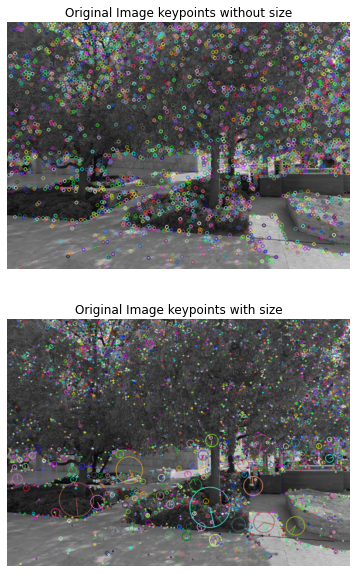

In [17]:
# train_dev_image_path = glob.glob('COMP90086_2021_Project_train/train/*.jpg')
rootpath = './small_train'
gray = cv2.imread(os.path.join(rootpath, 'IMG2744_1.jpg'),cv2.IMREAD_GRAYSCALE)

sift_main(gray)

In [4]:
cv2.__version__

'4.5.3'

In [76]:
import pandas as pd
train_csv = pd.read_csv("train.csv")
coords = []
for i in range(train_csv.shape[0]):
    
    x= train_csv.iloc[i]['x']
    y=train_csv.iloc[i]['y']
    coords.append((x, y))
    
print(len(set(coords)))

1499


---sift  0.04543590545654297 seconds ---
---flann  0.0007739067077636719 seconds ---
---knn  0.013291120529174805 seconds ---
---match 0.01367497444152832 seconds ---
---draw  0.004928112030029297 seconds ---


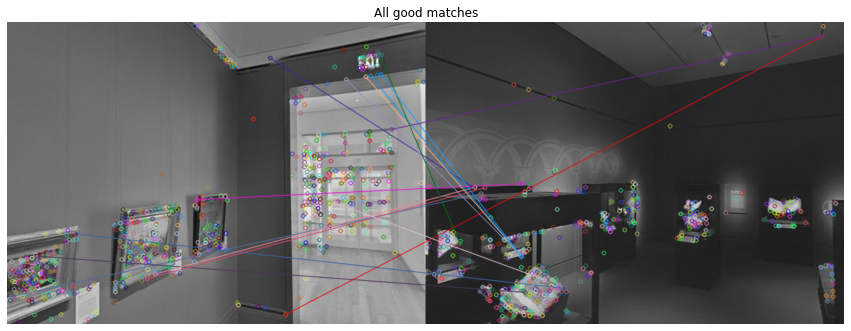


Number of good matches between two images:  15
image name is IMG3432_2.jpg
---sift  0.0644378662109375 seconds ---
---flann  0.00018310546875 seconds ---
---knn  0.04503488540649414 seconds ---
---match 0.045439958572387695 seconds ---
---sift  0.0571441650390625 seconds ---
---flann  0.0003147125244140625 seconds ---
---knn  0.022297143936157227 seconds ---
---match 0.022760391235351562 seconds ---
---sift  0.06313705444335938 seconds ---
---flann  0.00024199485778808594 seconds ---
---knn  0.03418087959289551 seconds ---
---match 0.034661054611206055 seconds ---
---sift  0.05813407897949219 seconds ---
---flann  0.0002770423889160156 seconds ---
---knn  0.027423858642578125 seconds ---
---match 0.027925968170166016 seconds ---
---draw  0.00913095474243164 seconds ---


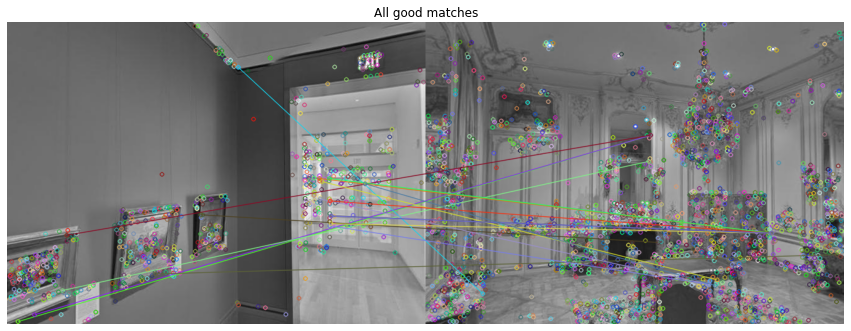


Number of good matches between two images:  17
image name is IMG4167_2.jpg
---sift  0.059797048568725586 seconds ---
---flann  0.00020885467529296875 seconds ---
---knn  0.015632152557373047 seconds ---
---match 0.016011953353881836 seconds ---
---sift  0.04754376411437988 seconds ---
---flann  0.000164031982421875 seconds ---
---knn  0.014477014541625977 seconds ---
---match 0.014935970306396484 seconds ---
---sift  0.04722785949707031 seconds ---
---flann  0.0002129077911376953 seconds ---
---knn  0.016530275344848633 seconds ---
---match 0.016909122467041016 seconds ---
---sift  0.04471397399902344 seconds ---
---flann  0.00019621849060058594 seconds ---
---knn  0.014011859893798828 seconds ---
---match 0.01442098617553711 seconds ---
---sift  0.04643893241882324 seconds ---
---flann  0.00020623207092285156 seconds ---
---knn  0.014079809188842773 seconds ---
---match 0.014733076095581055 seconds ---
---sift  0.06094622611999512 seconds ---
---flann  0.00017690658569335938 seconds 

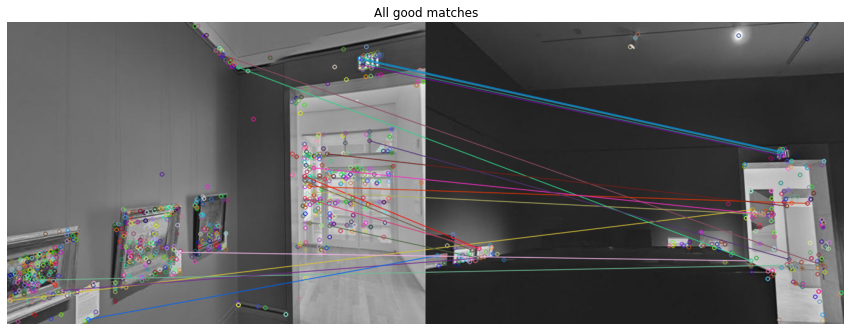


Number of good matches between two images:  21
image name is IMG3025_4.jpg
---sift  0.06333613395690918 seconds ---
---flann  0.00021696090698242188 seconds ---
---knn  0.022575855255126953 seconds ---
---match 0.023009061813354492 seconds ---
---sift  0.043321847915649414 seconds ---
---flann  0.00020122528076171875 seconds ---
---knn  0.01263284683227539 seconds ---
---match 0.01320505142211914 seconds ---
---sift  0.04204416275024414 seconds ---
---flann  0.00020503997802734375 seconds ---
---knn  0.011930704116821289 seconds ---
---match 0.012407779693603516 seconds ---
---sift  0.04552912712097168 seconds ---
---flann  0.00020599365234375 seconds ---
---knn  0.013883829116821289 seconds ---
---match 0.014306068420410156 seconds ---
---sift  0.04924416542053223 seconds ---
---flann  0.0002739429473876953 seconds ---
---knn  0.01862502098083496 seconds ---
---match 0.019033193588256836 seconds ---
---sift  0.04631185531616211 seconds ---
---flann  0.00021195411682128906 seconds ---

---knn  0.012961149215698242 seconds ---
---match 0.013368844985961914 seconds ---
---sift  0.06223702430725098 seconds ---
---flann  0.00022101402282714844 seconds ---
---knn  0.03248405456542969 seconds ---
---match 0.03296923637390137 seconds ---
---sift  0.04722929000854492 seconds ---
---flann  0.00024580955505371094 seconds ---
---knn  0.016333818435668945 seconds ---
---match 0.016723155975341797 seconds ---
---sift  0.04206991195678711 seconds ---
---flann  0.00017499923706054688 seconds ---
---knn  0.012366056442260742 seconds ---
---match 0.012797117233276367 seconds ---
---sift  0.047660112380981445 seconds ---
---flann  0.00016617774963378906 seconds ---
---knn  0.015064716339111328 seconds ---
---match 0.015558958053588867 seconds ---
---sift  0.04568600654602051 seconds ---
---flann  0.00025391578674316406 seconds ---
---knn  0.015736103057861328 seconds ---
---match 0.016190052032470703 seconds ---
---sift  0.047313690185546875 seconds ---
---flann  0.000202178955078125 

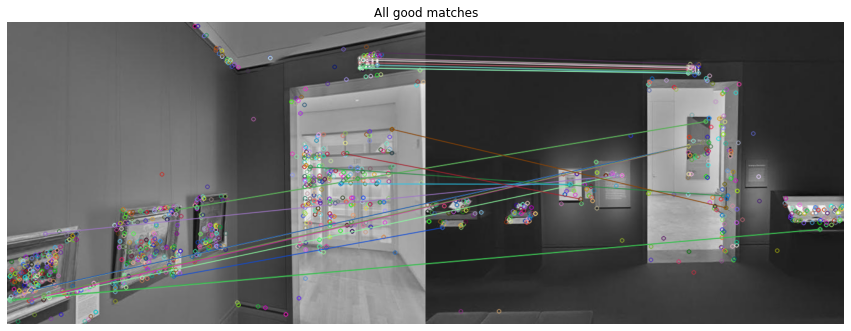


Number of good matches between two images:  24
image name is IMG4185_5.jpg
---sift  0.06110405921936035 seconds ---
---flann  0.00021600723266601562 seconds ---
---knn  0.01556086540222168 seconds ---
---match 0.016060829162597656 seconds ---
---sift  0.044860124588012695 seconds ---
---flann  0.0002110004425048828 seconds ---
---knn  0.01308894157409668 seconds ---
---match 0.013473987579345703 seconds ---
---sift  0.0413050651550293 seconds ---
---flann  0.0002048015594482422 seconds ---
---knn  0.011194944381713867 seconds ---
---match 0.011610984802246094 seconds ---
---sift  0.04521608352661133 seconds ---
---flann  0.00021600723266601562 seconds ---
---knn  0.013039112091064453 seconds ---
---match 0.013435125350952148 seconds ---
---sift  0.047453880310058594 seconds ---
---flann  0.0002491474151611328 seconds ---
---knn  0.017167091369628906 seconds ---
---match 0.01767706871032715 seconds ---
---sift  0.04413199424743652 seconds ---
---flann  0.00021409988403320312 seconds --

---sift  0.04647707939147949 seconds ---
---flann  0.0001647472381591797 seconds ---
---knn  0.014438152313232422 seconds ---
---match 0.014868021011352539 seconds ---
---sift  0.050894737243652344 seconds ---
---flann  0.00016736984252929688 seconds ---
---knn  0.01620769500732422 seconds ---
---match 0.0167238712310791 seconds ---
---sift  0.048310041427612305 seconds ---
---flann  0.0002281665802001953 seconds ---
---knn  0.014503955841064453 seconds ---
---match 0.015004873275756836 seconds ---
---sift  0.05720973014831543 seconds ---
---flann  0.0003581047058105469 seconds ---
---knn  0.02759099006652832 seconds ---
---match 0.02814507484436035 seconds ---
---sift  0.04221200942993164 seconds ---
---flann  0.00016117095947265625 seconds ---
---knn  0.011845827102661133 seconds ---
---match 0.012428760528564453 seconds ---
---sift  0.04284191131591797 seconds ---
---flann  0.00024008750915527344 seconds ---
---knn  0.012131929397583008 seconds ---
---match 0.012534141540527344 seco

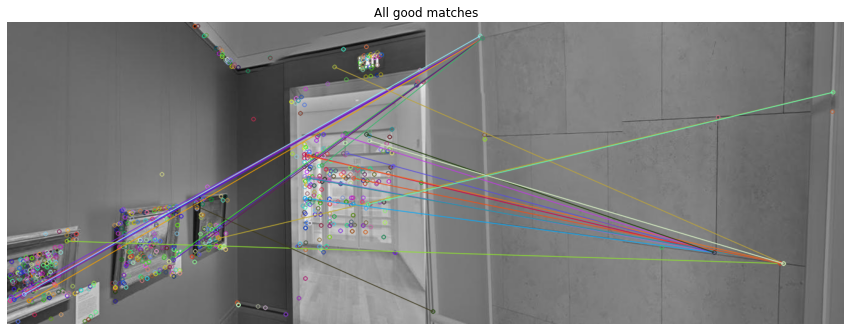


Number of good matches between two images:  27
image name is IMG3241_4.jpg
---sift  0.06430530548095703 seconds ---
---flann  0.0002110004425048828 seconds ---
---knn  0.01746082305908203 seconds ---
---match 0.0179598331451416 seconds ---
---sift  0.05077314376831055 seconds ---
---flann  0.00021576881408691406 seconds ---
---knn  0.01923394203186035 seconds ---
---match 0.019733905792236328 seconds ---
---sift  0.054242849349975586 seconds ---
---flann  0.0002460479736328125 seconds ---
---knn  0.02177715301513672 seconds ---
---match 0.02229022979736328 seconds ---
---sift  0.05228686332702637 seconds ---
---flann  0.0002262592315673828 seconds ---
---knn  0.018368959426879883 seconds ---
---match 0.018921852111816406 seconds ---
---sift  0.05641508102416992 seconds ---
---flann  0.00019311904907226562 seconds ---
---knn  0.023022890090942383 seconds ---
---match 0.023529052734375 seconds ---
---sift  0.05333995819091797 seconds ---
---flann  0.0002040863037109375 seconds ---
---kn

---sift  0.05328202247619629 seconds ---
---flann  0.00021195411682128906 seconds ---
---knn  0.02271890640258789 seconds ---
---match 0.023284912109375 seconds ---
---sift  0.05436110496520996 seconds ---
---flann  0.00021600723266601562 seconds ---
---knn  0.02042698860168457 seconds ---
---match 0.021297931671142578 seconds ---
---sift  0.05143475532531738 seconds ---
---flann  0.00024437904357910156 seconds ---
---knn  0.02145671844482422 seconds ---
---match 0.021887779235839844 seconds ---
---sift  0.04539203643798828 seconds ---
---flann  0.0002079010009765625 seconds ---
---knn  0.01011514663696289 seconds ---
---match 0.010551214218139648 seconds ---
---draw  0.0045697689056396484 seconds ---


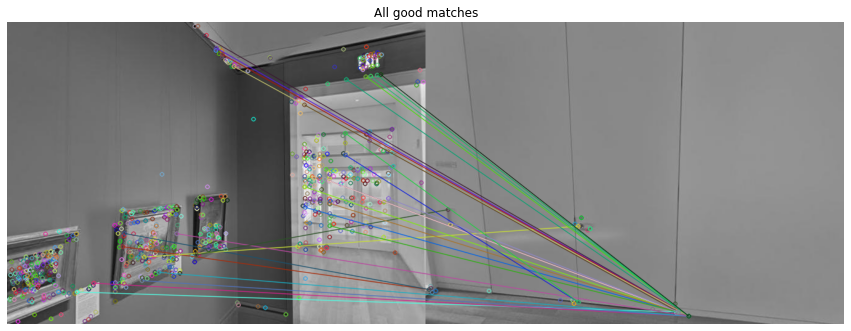


Number of good matches between two images:  28
image name is IMG3265_5.jpg
---sift  0.06594514846801758 seconds ---
---flann  0.0002079010009765625 seconds ---
---knn  0.01955699920654297 seconds ---
---match 0.020325183868408203 seconds ---
---sift  0.04292917251586914 seconds ---
---flann  0.0003337860107421875 seconds ---
---knn  0.013822078704833984 seconds ---
---match 0.014261960983276367 seconds ---
---sift  0.04622220993041992 seconds ---
---flann  0.00021982192993164062 seconds ---
---knn  0.016451120376586914 seconds ---
---match 0.016904115676879883 seconds ---
---sift  0.044415950775146484 seconds ---
---flann  0.0002911090850830078 seconds ---
---knn  0.015766143798828125 seconds ---
---match 0.016186952590942383 seconds ---
---sift  0.044107913970947266 seconds ---
---flann  0.00021386146545410156 seconds ---
---knn  0.013168096542358398 seconds ---
---match 0.01355123519897461 seconds ---
---sift  0.05135011672973633 seconds ---
---flann  0.00027680397033691406 seconds 

---knn  0.014715909957885742 seconds ---
---match 0.015143871307373047 seconds ---
---sift  0.05698394775390625 seconds ---
---flann  0.00023984909057617188 seconds ---
---knn  0.027128219604492188 seconds ---
---match 0.027569055557250977 seconds ---
---sift  0.042401790618896484 seconds ---
---flann  0.00021028518676757812 seconds ---
---knn  0.013341903686523438 seconds ---
---match 0.01378774642944336 seconds ---
---sift  0.04639601707458496 seconds ---
---flann  0.0002009868621826172 seconds ---
---knn  0.01657581329345703 seconds ---
---match 0.016976118087768555 seconds ---
---sift  0.04435086250305176 seconds ---
---flann  0.00015997886657714844 seconds ---
---knn  0.015486955642700195 seconds ---
---match 0.015917062759399414 seconds ---
---sift  0.04208803176879883 seconds ---
---flann  0.00023603439331054688 seconds ---
---knn  0.011693000793457031 seconds ---
---match 0.012113094329833984 seconds ---
---sift  0.049706220626831055 seconds ---
---flann  0.00026988983154296875

---knn  0.014185905456542969 seconds ---
---match 0.014680862426757812 seconds ---
---sift  0.042406320571899414 seconds ---
---flann  0.0002579689025878906 seconds ---
---knn  0.012387752532958984 seconds ---
---match 0.03684592247009277 seconds ---
---sift  0.043910980224609375 seconds ---
---flann  0.00020694732666015625 seconds ---
---knn  0.014600038528442383 seconds ---
---match 0.015065908432006836 seconds ---
---sift  0.03806185722351074 seconds ---
---flann  0.00035500526428222656 seconds ---
---sift  0.04346871376037598 seconds ---
---flann  0.00013208389282226562 seconds ---
---knn  0.013955116271972656 seconds ---
---match 0.01447296142578125 seconds ---
---sift  0.047772884368896484 seconds ---
---flann  0.00024318695068359375 seconds ---
---knn  0.015309810638427734 seconds ---
---match 0.01570582389831543 seconds ---
---sift  0.05127692222595215 seconds ---
---flann  0.0001850128173828125 seconds ---
---knn  0.015881061553955078 seconds ---
---match 0.01630401611328125 s

KeyboardInterrupt: 

In [7]:
# SIFT
import time
start_time = time.time()

imgA = cv2.imread('IMG4287_3.jpg', cv2.IMREAD_GRAYSCALE)

sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(imgA,None)

bestmatch = None
best_num = 0

rootpath = 'COMP90086_2021_Project_train/train'
for filename in os.listdir(rootpath):
    

    imgB = cv2.imread(os.path.join(rootpath, filename),cv2.IMREAD_GRAYSCALE)
    sift_start = time.time()
    kp2, des2 = sift.detectAndCompute(imgB,None)
    
    sift_time = time.time()
    print("---sift  %s seconds ---" % (sift_time - sift_start)) 
    
    # FLANN parameters and initialize
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)   # or pass empty dictionary
    flann = cv2.FlannBasedMatcher(index_params,search_params)

    flann_time = time.time()
    print("---flann  %s seconds ---" % (flann_time - sift_time)) 
    
    # Matching descriptor using KNN algorithm
    try:
        matches = flann.knnMatch(des1,des2,k=2)
    except:
        continue
        
    knn_time = time.time()
    print("---knn  %s seconds ---" % (knn_time - flann_time)) 
    # Create a mask to draw all good matches
    matchesMask = []

    # Store all good matches as per Lowe's Ratio test.
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)
            matchesMask.append([1,0]) # Match
        else:
            matchesMask.append([0,0]) # Mismatch
            
    match_time = time.time()
    print("---match %s seconds ---" % (match_time - flann_time))
    
    if len(good) <= best_num:
        continue
    # Draw all good matches
    
    draw_params = dict(#matchColor = (0,255,0),  #If you want a specific colour
                       #singlePointColor = (255,0,0), #If you want a specific colour
                        matchesMask = matchesMask,
                        flags = cv2.DrawMatchesFlags_DEFAULT)

    good_matches = cv2.drawMatchesKnn(imgA,kp1,imgB,kp2,matches,None,**draw_params)
    
    draw_time = time.time()
    print("---draw  %s seconds ---" % (draw_time - match_time))
    
    bestmatch = good_matches
    best_num = len(good)
        
    plt.figure(figsize=(15, 15))

    plt.imshow(good_matches)
    plt.title('All good matches')
    plt.axis('off')

    plt.show()

    # Print total number of good matches between two images
    print("\nNumber of good matches between two images: ", len(good))
    print("image name is", filename)
    
    
print("--- %s seconds ---" % (time.time() - start_time)) 
plt.figure(figsize=(15, 15))

plt.imshow(bestmatch)
plt.title('The best match')
plt.axis('off')

plt.show()

In [ ]:
# SURF
import time
start_time = time.time()

imgA = cv2.imread('IMG4287_3.jpg', cv2.IMREAD_GRAYSCALE)

sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(imgA,None)

bestmatch = None
best_num = 0

rootpath = 'COMP90086_2021_Project_train/train'
for filename in os.listdir(rootpath):
    imgB = cv2.imread(os.path.join(rootpath, filename),cv2.IMREAD_GRAYSCALE)
    kp2, des2 = surf.detectAndCompute(imgB,None)
    
    # FLANN parameters and initialize
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)   # or pass empty dictionary
    flann = cv2.FlannBasedMatcher(index_params,search_params)

    # Matching descriptor using KNN algorithm
    try:
        matches = flann.knnMatch(des1,des2,k=2)
    except:
        continue
    # Create a mask to draw all good matches
    matchesMask = []

    # Store all good matches as per Lowe's Ratio test.
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)
            matchesMask.append([1,0]) # Match
        else:
            matchesMask.append([0,0]) # Mismatch

    if len(good) <= best_num:
        continue
    # Draw all good matches
    draw_params = dict(#matchColor = (0,255,0),  #If you want a specific colour
                       #singlePointColor = (255,0,0), #If you want a specific colour
                        matchesMask = matchesMask,
                        flags = cv2.DrawMatchesFlags_DEFAULT)

    good_matches = cv2.drawMatchesKnn(imgA,kp1,imgB,kp2,matches,None,**draw_params)
    
    
    bestmatch = good_matches
    best_num = len(good)
        
    plt.figure(figsize=(15, 15))

    plt.imshow(good_matches)
    plt.title('All good matches')
    plt.axis('off')

    plt.show()

    # Print total number of good matches between two images
    print("\nNumber of good matches between two images: ", len(good))
    print("image name is", filename)
    
    
print("--- %s seconds ---" % (time.time() - start_time)) 
plt.figure(figsize=(15, 15))

plt.imshow(bestmatch)
plt.title('The best match')
plt.axis('off')

plt.show()

In [96]:
pip install opencv-contrib-python

     |████████████████████████████████| 51.4 MB 765 kB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.
